In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as KAA
from sklearn.preprocessing import StandardScaler, normalize
from utilities import focal_tversky, tversky_loss, tversky

import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Healthcare+AI+Datasets/Healthcare AI Datasets/Brain_MRI

/content/drive/MyDrive/Healthcare+AI+Datasets/Healthcare AI Datasets/Brain_MRI


In [4]:
brain_df = pd.read_csv('data_mask.csv')
brain_df

patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

## Data Visualization

In [5]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

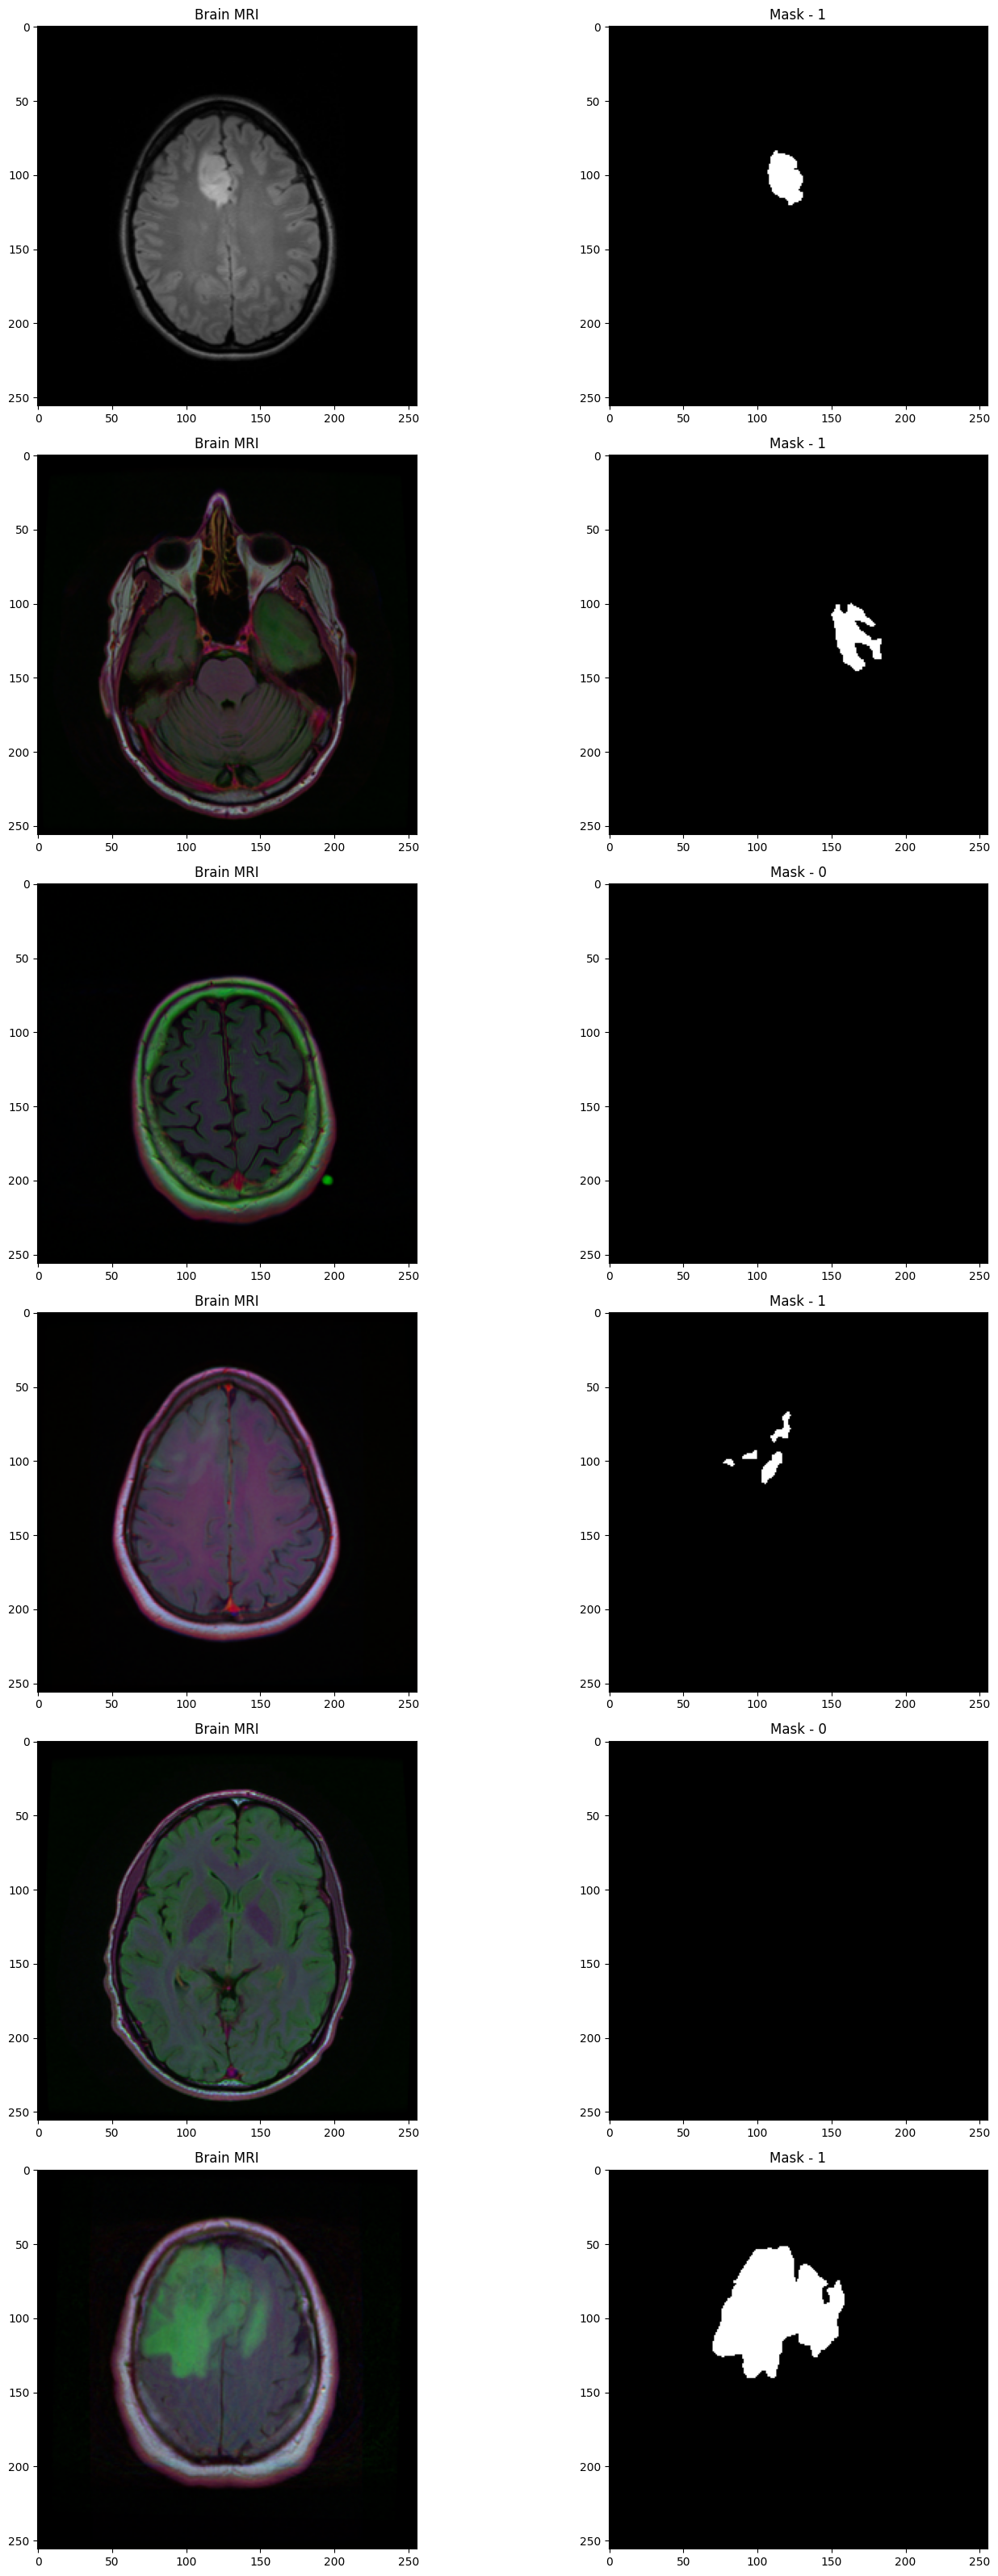

In [6]:
# Visualize the images (MRI - Mask)
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) 
  axs[count][0].title.set_text("Brain MRI")
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) 
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) 
  count += 1

fig.tight_layout()

In [14]:
brain_df['mask'] = brain_df['mask'].apply(lambda x: str(x))

In [13]:
# split the data into train and test data
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df, test_size = 0.15)

In [9]:
!pip install keras_preprocessing


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.9 MB/s eta 0:00:00


In [10]:
VAL_SPLIT = 0.15
IMAGE_SIZE = 256
IMAGE_CHAN = 3
BATCH_SIZE = 16

In [11]:
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255., validation_split = VAL_SPLIT)


In [12]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=BATCH_SIZE,
shuffle=True,
class_mode="categorical",
target_size=(IMAGE_SIZE,IMAGE_SIZE))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=BATCH_SIZE,
shuffle=True,
class_mode="categorical",
target_size=(IMAGE_SIZE,IMAGE_SIZE))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=BATCH_SIZE,
shuffle=False,
class_mode='categorical',
target_size=(IMAGE_SIZE,IMAGE_SIZE))



Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


### Developing a Classifier Model To Detect Brain Tumor 

In [13]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHAN)))

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [14]:
# freeze the model weights
for layer in basemodel.layers:
  layers.trainable = False


In [15]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)


In [16]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [17]:
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [19]:
class earlyStopAcc(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.99:
            self.model.stop_training = True
            print('Reached 99% accuracy, stopping training.')

callbacks = earlyStopAcc()

In [20]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks=[callbacks,checkpointer])


Epoch 1/10
178/178 [==============================] - ETA: 0s - loss: 0.8047 - accuracy: 0.7288 
Epoch 1: val_loss improved from inf to 0.68236, saving model to classifier-resnet-weights.hdf5
178/178 [==============================] - 2327s 13s/step - loss: 0.8047 - accuracy: 0.7288 - val_loss: 0.6824 - val_accuracy: 0.6220
Epoch 2/10
178/178 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.8137
Epoch 2: val_loss did not improve from 0.68236
178/178 [==============================] - 40s 226ms/step - loss: 0.4264 - accuracy: 0.8137 - val_loss: 0.8954 - val_accuracy: 0.6220
Epoch 3/10
178/178 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.8549
Epoch 3: val_loss did not improve from 0.68236
178/178 [==============================] - 40s 226ms/step - loss: 0.3463 - accuracy: 0.8549 - val_loss: 9.0716 - val_accuracy: 0.6220
Epoch 4/10
178/178 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.8824
Epoch 4: val_loss did no

In [21]:
# save the model architecture to json filee
model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

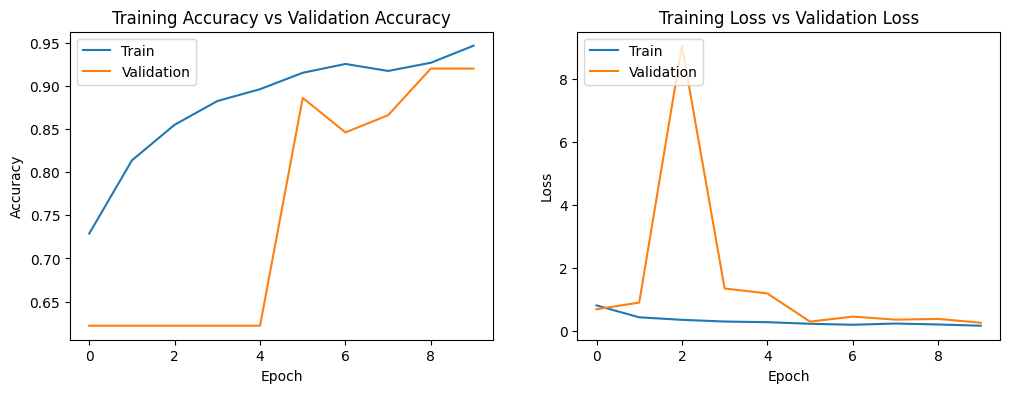

In [22]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [23]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 389s 11s/step


In [24]:
test_predict

array([[5.2313250e-01, 4.7567496e-01],
       [3.3152360e-01, 5.3402841e-01],
       [9.9842691e-01, 3.2981671e-04],
       ...,
       [9.9970090e-01, 3.8473314e-05],
       [1.8170524e-06, 9.8368144e-01],
       [5.1167026e-02, 6.9102901e-01]], dtype=float32)

In [25]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [26]:
len(predict)

576

In [27]:
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [28]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(original, predict)
accuracy

0.9201388888888888

<Axes: >

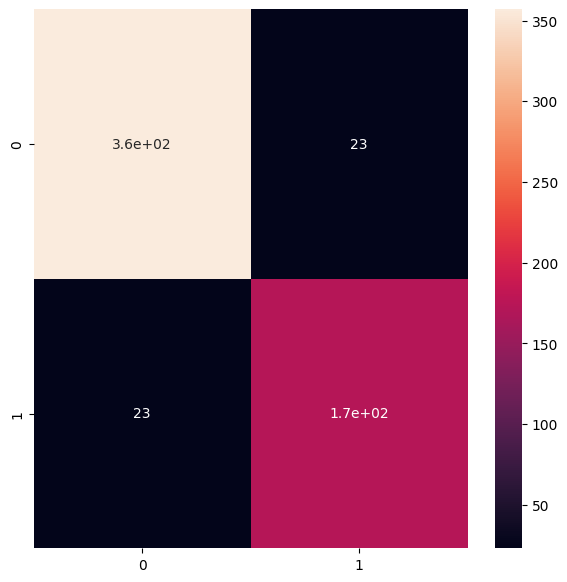

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [55]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       380
           1       0.88      0.88      0.88       196

   micro avg       0.92      0.92      0.92       576
   macro avg       0.91      0.91      0.91       576
weighted avg       0.92      0.92      0.92       576



/usr/local/lib/python3.9/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.9/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.9/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.9/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [11]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

## Build Segmentation Model to Localize Tumor

In [7]:
brain_df_mask = pd.read_csv('brain_df_mask.csv')
brain_df_mask

Unnamed: 0             patient_id  \
0            445  TCGA_DU_5872_19950223   
1            507  TCGA_DU_5874_19950510   
2            551  TCGA_DU_5854_19951104   
3            555  TCGA_DU_5854_19951104   
4            617  TCGA_DU_5853_19950823   
...          ...                    ...   
1368        3785  TCGA_HT_7684_19950816   
1369        3795  TCGA_HT_7684_19950816   
1370        3797  TCGA_HT_7684_19950816   
1371        3806  TCGA_HT_7684_19950816   
1372        3808  TCGA_HT_7684_19950816   

                                             image_path  \
0     TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif   
1     TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5.tif   
2     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6.tif   
3     TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6.tif   
4     TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif   
...                                                 ...   
1368  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_56...   
1369  TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_57...   
1370  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_57...   
1371  TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58...   
1372  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_58...   

                                              mask_path  mask  
0     TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5_...     1  
1     TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5_...     1  
2     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6_...     1  
3     TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6_...     1  
4     TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_...     1  
...                                                 ...   ...  
1368  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_56...     1  
1369  TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_57...     1  
1370  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_57...     1  
1371  TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58...     1  
1372  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_58...     1  

[1373 rows x 5 columns]

In [8]:
brain_df_mask['mask'] = brain_df_mask['mask'].apply(lambda x: str(x))

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [10]:

#Create a list for imageId and classId to pass in the generator
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [83]:
import keras
class DataGenerator(keras.utils.Sequence):
    def __init__(self, image_filenames, mask_filenames, batch_size=32):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size

    def __len__(self):
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.mask_filenames[idx * self.batch_size : (idx + 1) * self.batch_size]

        # Load images and masks
        batch_x = np.array([cv2.imread(file_name) for file_name in batch_x]) / 255.0 # normalize images
        batch_y = np.array([cv2.imread(file_name, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0 for file_name in batch_y])

        return batch_x, batch_y

In [84]:
training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [85]:
def resblock(X, f):
  # make a copy of input
  X_copy = X

  # main path
  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [62]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [77]:
input_shape = (256,256,3)
X_input = Input(input_shape)

conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

conv5_in = resblock(pool_4, 256)

up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [64]:
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [89]:
from utilities import tversky

In [90]:
import tensorflow as tf

@tf.function
def focal_tversky(y_true, y_pred):
    alpha = 0.7
    beta  = 0.3
    smooth = 1e-6
    
    # Flatten the inputs
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    
    # Calculate true positives, false positives, and false negatives
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    
    # Calculate Tversky score
    tversky_score = (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)
    
    # Calculate focal Tversky loss
    focal_tversky_loss = tf.pow(1 - tversky_score, 0.5)
    
    return focal_tversky_loss


In [91]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [92]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit(training_generator, epochs = 150, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

<ipython-input-83-d9bc66f27e22>:9: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 0.9647 - tversky: 0.1453
Epoch 1: val_loss improved from 0.97449 to 0.97357, saving model to ResUNet-weights.hdf5
37/37 [==============================] - 14s 379ms/step - loss: 0.9647 - tversky: 0.1453 - val_loss: 0.9736 - val_tversky: 0.1096
Epoch 2/100
37/37 [==============================] - ETA: 0s - loss: 0.9640 - tversky: 0.1481
Epoch 2: val_loss improved from 0.97357 to 0.97245, saving model to ResUNet-weights.hdf5
37/37 [==============================] - 15s 401ms/step - loss: 0.9640 - tversky: 0.1481 - val_loss: 0.9724 - val_tversky: 0.1140
Epoch 3/100
37/37 [==============================] - ETA: 0s - loss: 0.9633 - tversky: 0.1506
Epoch 3: val_loss improved from 0.97245 to 0.97120, saving model to ResUNet-weights.hdf5
37/37 [==============================] - 14s 387ms/step - loss: 0.9633 - tversky: 0.1506 - val_loss: 0.9712 - val_tversky: 0.1190
Epoch 4/100
37/37 [==============================] - ETA: 0s 

In [5]:
with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [15]:
from utilities import prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

1/1 [==============================] - 0s 265ms/step


In [16]:
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_2.tif   
1    TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_11...   
2    TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_12...   
3    TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_32...   
4    TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_16...   
..                                                 ...   
585  TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_19...   
586  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_41...   
587  TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_2.tif   
588  TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_10...   
589  TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_12...   

                                        predicted_mask  has_mask  
0                                              No mask         0  
1    [[[[1.0467481e-06], [5.357521e-06], [1.1778262...         1  
2                                              No mask         0  
3                                              No mask         0  
4    [[[[8.7850566e-07], [3.1529933e-06], [5.1284e-...         1  
..                                                 ...       ...  
585  [[[[7.233639e-07], [2.7730584e-06], [5.9065937...         1  
586  [[[[7.142406e-07], [2.5996076e-06], [4.7269205...         1  
587                                            No mask         0  
588                                            No mask         0  
589  [[[[7.443129e-07], [2.9355183e-06], [7.209477e...         1  

[590 rows x 3 columns]

In [19]:
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

patient_id                                         image_path  \
0  TCGA_CS_5397_20010315  TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_2.tif   
1  TCGA_DU_7014_19860618  TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_11...   
2  TCGA_DU_7008_19830723  TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_12...   
3  TCGA_HT_8018_19970411  TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_32...   
4  TCGA_DU_A5TR_19970726  TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_16...   

                                           mask_path  mask  \
0  TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_2_...     0   
1  TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_11...     1   
2  TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_12...     0   
3  TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_32...     0   
4  TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_16...     1   

                                      predicted_mask  has_mask  
0                                            No mask         0  
1  [[[[1.0467481e-06], [5.357521e-06], [1.1778262...         1  
2                                            No mask         0  
3                                            No mask         0  
4  [[[[8.7850566e-07], [3.1529933e-06], [5.1284e-...         1

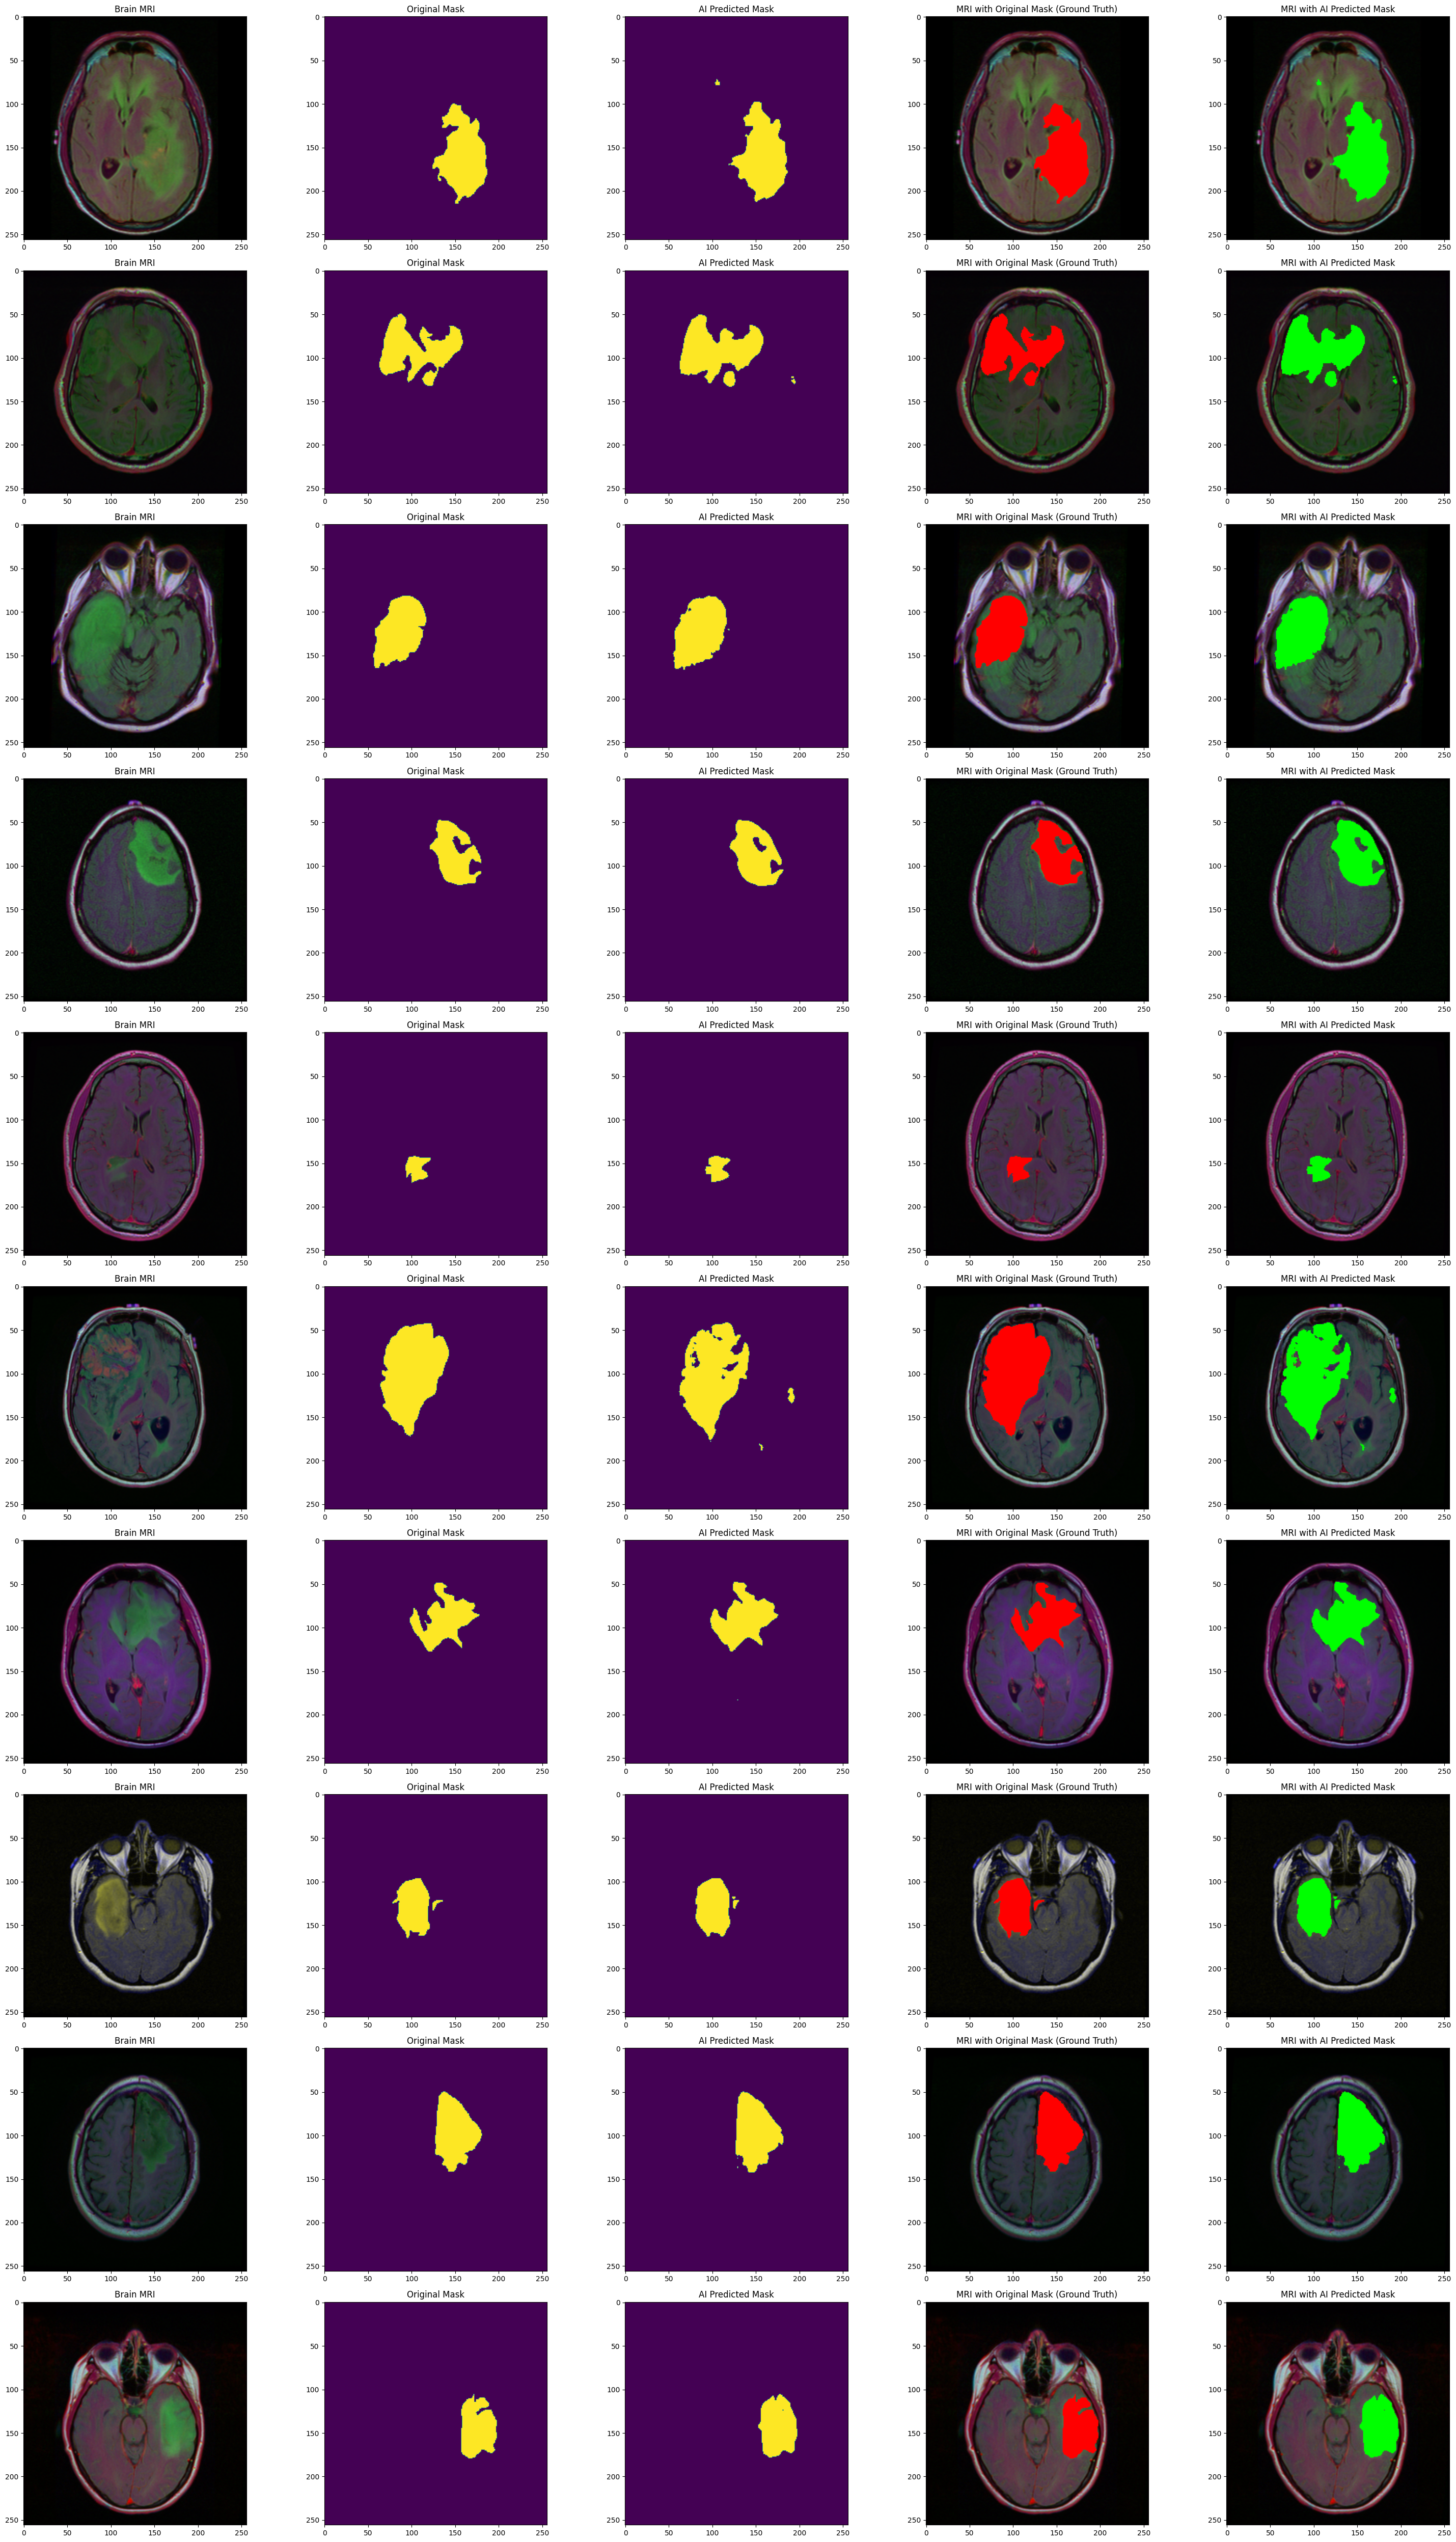

In [20]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()